In [23]:
import os
import random
import sys
import spacy
import en_core_sci_sm
import en_ner_craft_md
import en_ner_bc5cdr_md
import en_ner_bionlp13cg_md
import en_ner_jnlpba_md
import scispacy
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from spacy import displacy
from ipywidgets import interactive
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import cluster, datasets, metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
plt.style.use("seaborn")
pd.set_option("display.max_colwidth", 0)
%matplotlib inline

warnings.filterwarnings('ignore')

In [13]:
df_train = pd.read_csv('../data/Train.csv')
df_test = pd.read_csv('../data/Test.csv')
df_sub = pd.read_csv('../data/Sample Submission.csv')

In [14]:
df_train.head()

Id  \
0  1    
1  2    
2  3    
3  4    
4  5    

                                                                                                                                                                                                                                                                                                                        description  \
0   Patient had a recurrent left arm pain after her stent, three days ago, and this persisted after two sublingual nitroglycerin.                                                                                                                                                                                                     
1   The patient is an 84-year-old female presented to emergency room with shortness of breath, fatigue, and tiredness.  Low-grade fever was noted last few weeks.  The patient also has chest pain described as dull aching type in precordial region.  No relation to exertion or activity.  No aggravating or relieving factors.    
2   Hand dermatitis.                                                                                                                                                                                                                                                                                                                  
3   Recurrent degenerative spondylolisthesis and stenosis at L4-5 and L5-S1 with L3 compression fracture adjacent to an instrumented fusion from T11 through L2 with hardware malfunction distal at the L2 end of the hardware fixation.                                                                                              
4   Chiropractic IME with old files review.  Detailed Thoracic Spine Examination.                                                                                                                                                                                                                                                     

             medical_specialty              sample_name  \
0   Cardiovascular / Pulmonary   Angina - Consult         
1   Cardiovascular / Pulmonary   Pericardial Effusion     
2   Dermatology                  Dermatitis - SOAP        
3   Surgery                      Lumbar Re-exploration    
4   IME-QME-Work Comp etc.       Chiropractic IME - 2     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [33]:
# EDA

In [40]:
# unique medical specialty
df_train['medical_specialty'].value_counts()

 Surgery                          788
 Consult - History and Phy.       310
 Cardiovascular / Pulmonary       309
 Orthopedic                       294
 Radiology                        225
 Gastroenterology                 189
 General Medicine                 188
 Neurology                        166
 SOAP / Chart / Progress Notes    130
 ENT - Otolaryngology             79 
 Discharge Summary                75 
 Neurosurgery                     73 
 Hematology - Oncology            72 
 Nephrology                       69 
 Ophthalmology                    64 
 Pain Management                  55 
 Podiatry                         43 
 Office Notes                     35 
 Dermatology                      23 
 Psychiatry / Psychology          22 
 Dentistry                        21 
 Cosmetic / Plastic Surgery       19 
 Letters                          18 
 Physical Medicine - Rehab        17 
 Sleep Medicine                   17 
 Endocrinology                    14 
 IME-QME-Wor

In [41]:
# reduce data to only contain fewer specialties

In [39]:
filtered_data = df_train[['transcription', 'medical_specialty']]
filtered_data.loc[:, 'medical_specialty'] = filtered_data['medical_specialty'].apply(lambda x:str.strip(x))
mask = (filtered_data['medical_specialty'] == 'SOAP / Chart / Progress Notes') | \
       (filtered_data['medical_specialty'] == 'Office Notes') | \
       (filtered_data['medical_specialty'] == 'Consult - History and Phy.') | \
       (filtered_data['medical_specialty'] == 'Emergency Room Reports') | \
       (filtered_data['medical_specialty'] == 'Discharge Summary') | \
       (filtered_data['medical_specialty'] == 'Letters')
filtered_data = filtered_data[~mask]
data_categories  = filtered_data.groupby(filtered_data['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 60)
filtered_data_categories['medical_specialty'].value_counts()

Surgery                       788
Cardiovascular / Pulmonary    309
Orthopedic                    294
Radiology                     225
Gastroenterology              189
General Medicine              188
Neurology                     166
ENT - Otolaryngology          79 
Neurosurgery                  73 
Hematology - Oncology         72 
Nephrology                    69 
Ophthalmology                 64 
Name: medical_specialty, dtype: int64

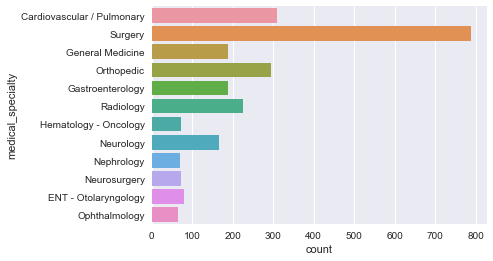

In [48]:
ax=sns.countplot(y=filtered_data_categories['medical_specialty'], orient = 'h')